*updated 21 Jan 2026, Julian Mak (whatever with copyright, do what you want with this)

### As part of material for OCES 5303 "AI and Machine Learning in Ocean Science" delivered at HKUST

For the latest version of the material, go to the public facing [GitHub](https://github.com/julianmak/OCES5303_ML_ocean) page.

---
# 6. Autoencoders

***Auto-encoders*** can be thought of as *unsupervised* neural networks, although they are trained in the supervising sense. The **auto** refers to output and input being (basically) the same (acting on itself in a sense). Here we are going to build various types of autoencoders and use it to do a few things; I am going to leverage the `keras` interface for this.

> ## Key Objective(s)
> 1. Introduce auto-encoders and demonstrate some possible uses of those.
> 2. Implement a convolution auto-encoder (CAE) for similar tasks.

> NOTE: Some of these can be a bit slow and you may want to put these on a GPU to do training with. If you use `keras` with the `PyTorch` backend, then it seems that as long as `PyTorch` can detect the GPU (and that may only be true for certain types/brands of GPUs), then the `keras` interface handles all the moving on and off the GPU already, so you ***probably*** don't need to do anything extra (which is big bonus of using `keras`; I say "probably" because I am not quite sure how to definitively check this...)
>
> In the PINNs session I will do everything in `PyTorch` instead and highlight some of the related syntax and subtleties you have to be careful of to make the code run with GPUs.

Loading some relevant packages first.

In [1]:
# load some packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler

# PyTorch
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# keras related
import os
os.environ["KERAS_BACKEND"] = "torch"  # use PyTorch as backend
import keras
import keras.layers as layers
keras.backend.clear_session() # force a clean keras session (clears models etc.)

from tqdm.keras import TqdmCallback

# check for GPUs availability
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cpu


---
## a) Structure and uses of auto-encoders

There are the two parts to the auto-encoder architecture:

1. The ***encoder***, which compresses information by squeezing the feature dimension down to some ***latent space***, and is a neural network of some description.
2. The ***decoder***, which blows up the latent space representation back up to the original dimension, and is a also neural network of some description.

Pictorially this is represented as follows:

<img src="https://i.imgur.com/n2dcFVU.png" width="600" alt='autoencoder'>

> NOTE: The decoder does not have to have a structure that exactly mirror the encoder or vice-versa. You just need them to have appropriate input/output dimensions.

The idea is that the encoder is trained to squash out the unnecessary information, resulting in a lower dimension representation. The decoder on the other hand is trained to recover the original data using that lower dimension representation. The below demonstrates two possible uses of this (although it's not done all that well, because the chosen problem is deliberately hard).

### 1) Latent space representation (cf. alternative to PCA et al.)

In session 2 we considered several ways to reduce the dimensionality of data, but we could also do it using neural networks. Going to do the easy case with `penguins` data first.

In [2]:
# load the penguin data
option = "remote"

if option == "local":
    print("loading data locally (assumes file has already been downloaded)")
    path = "penguins.csv"
elif option == "remote":
    print("loading data remotely")
    path = "https://raw.githubusercontent.com/julianmak/OCES5303_ML_ocean/refs/heads/main/penguins.csv"
else:
    raise ValueError("INVALID OPTION: use 'remote' or 'local'")

df = pd.read_csv(path)

features = ["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]
X = df[features].values
X_scaled = StandardScaler().fit_transform(X)

loading data remotely


Here I am going to define a really simple single layer autoencoder, consisting of `layer_in`, which is used in the encoder to map the four dimensional features space to two, and `layer_out`, which is the decoder to map it back to four dimensions, both to have ReLU as the activation function. The forward then consists of encoder followed by the decoder.

I am writing this as a subroutine to wrap up the models in a slightly more tidy way. The sequence of operations in this case is taped accordingly by `keras`. I am outputting all three (uncompiled) models because I want to use all three of them separately.

In [3]:
# define really simple auto-encoder (two parts jammed together: encoder and decoder)

def ae_penguin():

    # 1) define the autoencoder and the layers: 4 dim -> 2 dim -> 4 dim
    inputs = keras.Input(shape=(4,))
    encoded = layers.Dense(2, activation='relu')(inputs)
    decoded = layers.Dense(4, activation='relu')(encoded)
    autoencoder = keras.Model(inputs, decoded, name="autoencoder")

    # 2) pull out the encoder, 4 dim -> 2 dim
    encoder = keras.Model(inputs, encoded, name="encoder")

    # 3) pull out the decoder, 2 dim -> 4 dim (this one needs a bit more syntax)
    encoded_input = keras.Input(shape=(2,))
    decoder_layer = autoencoder.layers[-1]
    decoder = keras.Model(encoded_input, decoder_layer(encoded_input), name="decoder")

    return autoencoder, encoder, decoder

# initialise the model and see what it has
dummy, _, _ = ae_penguin()
dummy.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 4)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │            10 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │            12 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22 (88.00 B)

 Trainable params: 22 (88.00 B)

 Non-trainable params: 0 (0.00 B)

For this auto-encoder, the input and output data is the same. Below sets the seed, initialises model, compiles the options and trains it (it's just a copy-and-paste job from last time, with the validation part removed). 

Instead of leveraging batching through `DataLoader` I've set batching on through the `autoencoder.fit(..., batch_size=...)`, showing extra power of `keras` in interfacing things in a neat way.

> NOTE: Not going to use `Dataset` and `DataLoader` for this one just to demonstrate some syntax. Observe we also don't need to turn these into tensors if we are using `keras`, which is quite convenient.

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

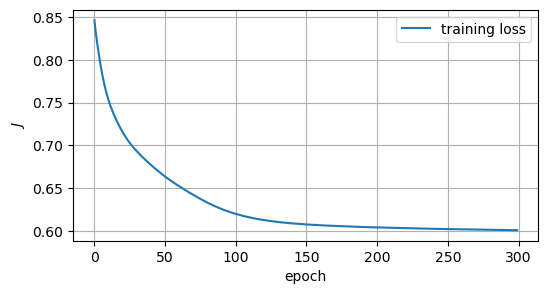

In [4]:
# initialise, compile and train the model

# define data
X_train, Y_train = X_scaled, X_scaled

keras.utils.set_random_seed(4321)

# initialise model
autoencoder, encoder, decoder = ae_penguin()

# compile
learning_rate = 0.001
autoencoder.compile(loss=keras.losses.MeanSquaredError(), 
                    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                    )

# train
train_log = autoencoder.fit(X_train, Y_train, 
                            epochs=300,
                            batch_size=50,
                            verbose=0,
                            callbacks=[TqdmCallback(verbose=1)],
                           )

# plot the loss curves
fig = plt.figure(figsize=(6, 3))
ax = plt.axes()
ax.plot(train_log.epoch, train_log.history["loss"], label="training loss")
ax.set_xlabel("epoch")
ax.set_ylabel(r"$J$")
ax.grid()
ax.legend();

For this one I am mainly interested in showing the ***latent*** space representation. This I can get by calling the encoder part of the model, and because I chose my encoder to map from four to two dimensions. Below does the call and plots out the results, labelled by the species.

> NOTE: Here I don't need to set whether the model is in training or predictive mode when using `keras`, which I would probably should do if I were doing this through `PyTorch`.
>
> Note also that even though I trained the `autoencoder`, the `encoder` knows the resulting weights, thanks to the appropriate taping of operations enabled through `keras`. In `PyTorch` this is also true, although you'd need to define the encoder and decoder probably as a subroutine within the neural network class object.

11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


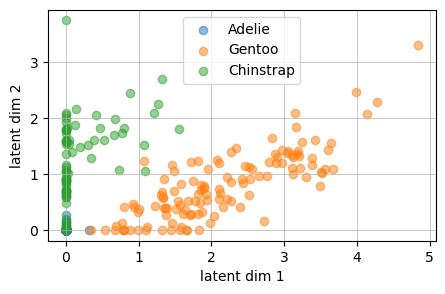

In [5]:
# latent space representation
latent_rep_train = encoder.predict(X_train)

fig = plt.figure(figsize=(5, 3))
ax = plt.axes()
for species in df["species"].unique():   # pick out all unique entries under `species`
    ax.scatter(latent_rep_train[df["species"] == species, 0],
               latent_rep_train[df["species"] == species, 1],
               label=species,
               alpha=0.5,  # fade this for demonstration later
               )
ax.set_xlabel(f"latent dim 1")
ax.set_ylabel(f"latent dim 2")
ax.grid(lw=0.5, zorder=0)
ax.legend();

You can think of this as a neural network equivalent of PCA or similar, where the network finds the optimal co-ordinate transformation/project (note for most of my attempts the `Adelie` class gets mapped to things close to zero though...) 

Given enough depth and breadth it may be that the auto-encoder captures a good latent space representation that may be computationally out of reach with other procedures.

### 2) Generating new data from the decoder

Above only really uses the encoder, but you could imagine that you can choose numbers strategically in the latent space representation, feed that into the decoder to artificially generate new data; this may be a useful way to generate new data from an existing dataset. Below is an example taken from the keras blog for Variational Autoencoder for the MNIST dataset, where each image is generated by specifying two numbers (or a point in the latent space plane in this case):

<img src="https://blog.keras.io/img/ae/vae_digits_manifold.png" width="400" alt='vae generative from keras'>

An equivalent larger dimension problem would be you take a set of images, train an auto-encoder, and use the decoder part to generate new images. Going to briefly show how that works with the cats image set.

> NOTE: It doesn't work very well here because the number of images is rather low, and also to make the model train in sensible time I didn't make the auto-encoder too deep or wide. 
>
> In this case having CNN based encoders and decoders would probably work better anyway; see later.

In [6]:
# don't read the headers

option = "remote"

if option == "local":
    print("loading data locally (assumes file has already been downloaded)")
    path = "cat.csv"
elif option == "remote":
    print("loading data remotely")
    path = "https://raw.githubusercontent.com/julianmak/OCES5303_ML_ocean/refs/heads/main/cat.csv"
else:
    raise ValueError("INVALID OPTION: use 'remote' or 'local'")

df_cats = pd.read_csv(path, header=None).T # make "features" the axis=-1
X_cats = df_cats.values

if option == "local":
    print("loading data locally (assumes file has already been downloaded)")
    path = "dog.csv"
elif option == "remote":
    print("loading data remotely")
    path = "https://raw.githubusercontent.com/julianmak/OCES5303_ML_ocean/refs/heads/main/dog.csv"
else:
    raise ValueError("INVALID OPTION: use 'remote' or 'local'")

df_dogs = pd.read_csv(path, header=None).T # make "features" the axis=-1
X_dogs = df_dogs.values

loading data remotely
loading data remotely


In [7]:
# load data
seed = 42

# normalise to [0, 1]
X_total = X_cats / 255 # TODO: cat/dog mix to generate more cursed examples?
Y_total = X_cats / 255

# only do train/test split; validation split later with keras
X_train, X_test, Y_train, Y_test = train_test_split(
    X_total, Y_total, train_size=0.90, random_state=seed,)

# check the shape
print()
print(f"X_train shape : {X_train.shape}; Y_train shape: {Y_train.shape}")
print(f"X_test shape: {X_test.shape}; Y_test shape: {Y_test.shape}")

# check the range of values
print()
print(f"X_train : {X_train.min()}...{X_train.max()}")
print(f"X_test :  {X_test.min()}...{X_test.max()}")


X_train shape : (72, 4096); Y_train shape: (72, 4096)
X_test shape: (8, 4096); Y_test shape: (8, 4096)

X_train : 0.0...1.0
X_test :  0.0...1.0


In the autoencoder below I make it go from $64^2$ to $16^2$ then $4^2$ with the usual fully connected neural networks, then I reverse that process. The jumps in the dimensions are reasonably big, so we don't really expect this to work all that well.

In [8]:
# define really simple auto-encoder (two parts jammed together: encoder and decoder)

def ae_catdog():

    # 1) define the autoencoder and the layers
    inputs = keras.Input(shape=(64**2,))
    encoded = keras.Sequential(
        [
            layers.Dense(16**2, activation='relu'),  # no input here
            layers.Dense(4**2, activation='relu'),
        ]
    )(inputs)  # input to be passed here
    decoded = keras.Sequential(
        [
            layers.Dense(16**2, activation='relu'),
            layers.Dense(64**2, activation='sigmoid'),
        ]
    )(encoded)
    autoencoder = keras.Model(inputs, decoded, name="autoencoder")

    # 2) pull out the encoder
    encoder = keras.Model(inputs, encoded, name="encoder")

    # 3) pull out the decoder (this one needs a bit more syntax)
    encoded_input = keras.Input(shape=(4**2,))
    decoder_layer = autoencoder.layers[-1]
    decoder = keras.Model(encoded_input, decoder_layer(encoded_input), name="decoder")

    return autoencoder, encoder, decoder

# initialise the model and see what it has
dummy, _, _ = ae_catdog()
dummy.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 16)             │     1,052,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 4096)           │     1,057,024 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,109,968 (8.05 MB)

 Trainable params: 2,109,968 (8.05 MB)

 Non-trainable params: 0 (0.00 B)

The data has already been prepped so I just go ahead with throwing it in (again as `numpy` arrays). Three things I did slightly different here:

* I used `optimizers.AdamW` instead of the usual `Adam` with the `weight_decay` option, which is a regulariser of sorts for the solver (this I got from Jonathan)
* Instead of defining validation dataset manually, I split this out from the train set through `keras` via `.fit(..., validation_split=0.2, ...)`, which is splitting out 20% of the train set for validation.
* I don't do batching here; there is no particular reason for this except for comparing with my other implementation in `PyTorch`.

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

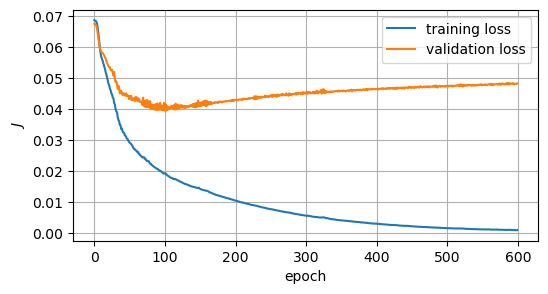

In [9]:
# intialise model, compile, train and plot loss

keras.utils.set_random_seed(4321)

# initialise model
autoencoder, encoder, decoder = ae_catdog()

# compile
learning_rate = 0.0005
autoencoder.compile(loss=keras.losses.MeanSquaredError(), 
                    # note the use of a different Adam
                    optimizer=keras.optimizers.AdamW(learning_rate=learning_rate,
                                                     weight_decay=0.001),
                    )

# train + validation (split out 20% of train data for validation)
train_log = autoencoder.fit(X_train, Y_train, 
                            epochs=600,
                            validation_split=0.2,  # get validation data from train set
                            verbose=0,
                            callbacks=[TqdmCallback(verbose=1)],
                           )

# plot the loss curves
fig = plt.figure(figsize=(6, 3))
ax = plt.axes()
ax.plot(train_log.epoch, train_log.history["loss"], label="training loss")
ax.plot(train_log.epoch, train_log.history["val_loss"], label="validation loss")
ax.set_xlabel("epoch")
ax.set_ylabel(r"$J$")
ax.grid()
ax.legend();

It looks not unreasonable on the training loss, but it's pretty bad on the validation dataset. Again this is not entirely surprising, because I have kept the dataset size and neural network complexity low for speed reasons. The below code runs a model prediction to see what the results look like on both the train and test set.

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


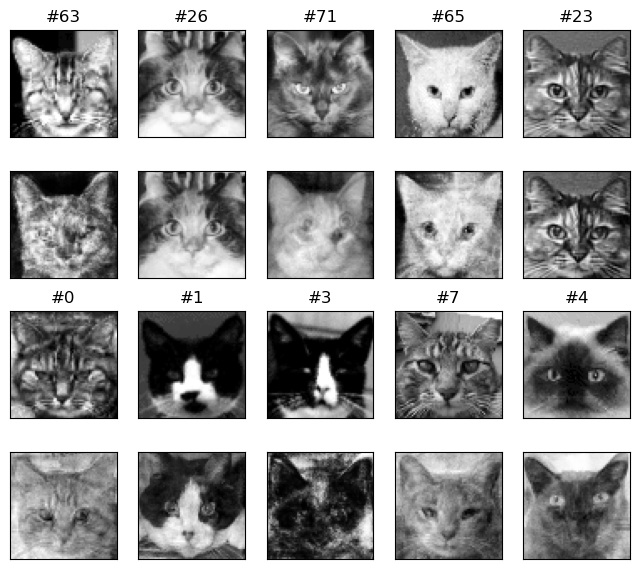

In [10]:
# sample show
predictions_train = autoencoder.predict(X_train)
predictions_test = autoencoder.predict(X_test)

# generate a list of indices (generate full list, shuffle, select first bit, so no repeats)
ind = np.arange(X_train.shape[0])
np.random.seed(123)
np.random.shuffle(ind)  # syntax for shuffle: not used like a function with input output...

fig = plt.figure(figsize=(8, 7))
for i in range(5):
    ax = plt.subplot(4, 5, i+1)
    ax.imshow(np.reshape(X_train[ind[i], :], (64, 64)).T, cmap="gray")
    ax.set_title(f"#{ind[i]}")
    ax.set_xticks([]); ax.set_yticks([]);
    ax = plt.subplot(4, 5, 5+i+1)
    ax.imshow(np.reshape(predictions_train[ind[i], :], (64, 64)).T, cmap="gray")
    ax.set_xticks([]); ax.set_yticks([]);

# same for test set
ind = np.arange(X_test.shape[0])
np.random.seed(123)
np.random.shuffle(ind)

for i in range(5):
    ax = plt.subplot(4, 5, 10+i+1)
    ax.imshow(np.reshape(X_test[ind[i], :], (64, 64)).T, cmap="gray")
    ax.set_title(f"#{ind[i]}")
    ax.set_xticks([]); ax.set_yticks([]);
    ax = plt.subplot(4, 5, 10+5+i+1)
    ax.imshow(np.reshape(predictions_test[ind[i], :], (64, 64)).T, cmap="gray")
    ax.set_xticks([]); ax.set_yticks([]);

(Again, I never said this was going to "good"!)

We can now do a "PCA" like thing by calling only the encoder to give us the latent space representation.

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


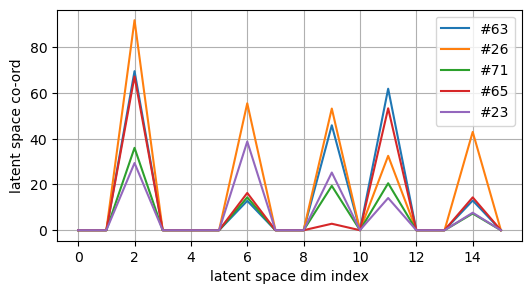

In [11]:
# latent space representation
latent_rep_train = encoder.predict(X_train)

# generate the same indices used in the above for train set
ind = np.arange(X_train.shape[0])
np.random.seed(123)
np.random.shuffle(ind)

# plot out
fig = plt.figure(figsize=(6, 3))
ax = plt.axes()
for i in range(5):
    ax.plot(latent_rep_train[ind[i], :], label=f"#{ind[i]}")
ax.set_xlabel(r"latent space dim index")
ax.set_ylabel(r"latent space co-ord")
ax.legend()
ax.grid();

Each image thus has a "barcode" of sorts tagged with it, given by the numbers associated with each latent space dimension (cf. the PCs under the EOF transformation). You might expect images that are more "alike" (in whatever sense the neural networks decided for it to mean) would be closer to each other.

> NOTE: We may come back to this point relating to barcodes if we talk about ***topological data analysis***.

Now you could choose a selection of numbers (16 in this case), pass it to the *decoder*, and it will spit out an image for you. This we will try now, by:

1. Throwing in a "mean" barcode by taking the mean value of the above.
2. Throwing in a "random" barcode, by randomly selecting existing values from the training dataset as we cycle through the latent space dimension.

> NOTE: The "random" one is constrained to be sampled from the training dataset, because making it truly random is probably going to do something weird; you can try this yourselves.

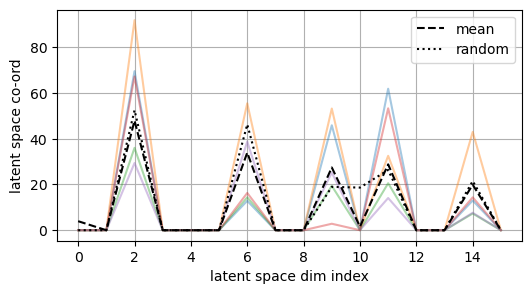

In [12]:
# generate two additional barcodes and plot that out

# take an "average" along the components
mean_representation = np.mean(latent_rep_train, axis=0)

# randomly select some values for the representation from existing pool
n_samples, n_dim = latent_rep_train.shape
rand_representation = np.zeros(n_dim)
for i in range(len(rand_representation)):
    rand_representation[i] = latent_rep_train[np.random.randint(n_samples), i]

# plot out
fig = plt.figure(figsize=(6, 3))
ax = plt.axes()
for i in range(5):
    ax.plot(latent_rep_train[ind[i], :], alpha=0.4)
ax.plot(mean_representation, 'k--', label="mean")
ax.plot(rand_representation, 'k:', label="random")
ax.set_xlabel(r"latent space dim index")
ax.set_ylabel(r"latent space co-ord")
ax.legend()
ax.grid();

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


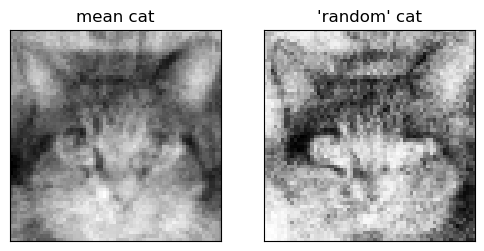

In [13]:
# cursed beast from decoder
gen_mean = decoder.predict(mean_representation.reshape(1, 16))
gen_rand = decoder.predict(rand_representation.reshape(1, 16))

fig = plt.figure(figsize=(6, 3))
ax = plt.subplot(1, 2, 1)
ax.imshow(np.reshape(gen_mean, (64, 64)).T, cmap="gray")
ax.set_xticks([]); ax.set_yticks([]);
ax.set_title(r"mean cat")

ax = plt.subplot(1, 2, 2)
ax.imshow(np.reshape(gen_rand, (64, 64)).T, cmap="gray")
ax.set_xticks([]); ax.set_yticks([]);
ax.set_title(r"'random' cat");

Again, I never said they were going to be good!

> <span style="color:red">Q.</span> Try randomly generating a barcode to pass to the encoder to generate more cursed images.
>
> <span style="color:red">Q.</span> Try doing similar things but now including cats and dogs. Investigate if the latent space representation of the two classes look distinctly different, which would indicate it may have skill in doing classification problems (e.g. session 3, or doing classification with neural networks).
>
> Also see what kind of cursed cat-dog things you can generate.

### 3) De-noising data

One application we could use with an autoencoder is ***de-noising*** the data. The idea here is that the output is clean data, while the input is the same data but with noise in, so the autoencoder is trained to remove the noise via some compression and decompression. For this we can more or less do a copy-and-paste job from above, where the only difference is what we put in as input and output data. The below set of code basically does this.

In [14]:
# load the data again for safety
seed = 42

# normalise to [0, 1]
X_total = X_cats / 255 # TODO: cat/dog mix to generate more cursed examples?
Y_total = X_cats / 255

# only do train/test split; validation split later with keras
X_train, X_test, Y_train, Y_test = train_test_split(
    X_total, Y_total, train_size=0.90, random_state=seed,)

# check the shape
print()
print(f"X_train shape : {X_train.shape}; Y_train shape: {Y_train.shape}")
print(f"X_test shape: {X_test.shape}; Y_test shape: {Y_test.shape}")

# check the range of values
print()
print(f"X_train : {X_train.min()}...{X_train.max()}")
print(f"X_test :  {X_test.min()}...{X_test.max()}")


X_train shape : (72, 4096); Y_train shape: (72, 4096)
X_test shape: (8, 4096); Y_test shape: (8, 4096)

X_train : 0.0...1.0
X_test :  0.0...1.0


Here I am going to add some Gaussian noise to the data with some specified `noise_level`, and then plot out some of the noisy and clean image that are exposed to the autoencoder.

> NOTE: My expectation here is that the larger the `noise_level` the harder the autoencoder has to work to remove it; play around with this for later to investigate whether that is true.

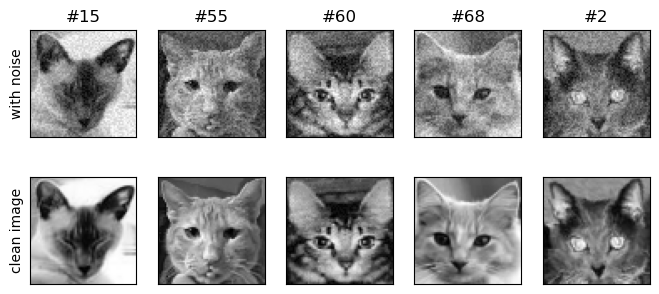

In [15]:
# denoising: add noise to the X_train but keep Y_train clean

noise_level = 0.2  # uniform noise with some magnitude (data here is NORMALISED to [0, 1])

X_train += noise_level * np.random.rand(X_train.shape[0], 
                                        X_train.shape[1])
X_test  += noise_level * np.random.rand(X_test.shape[0], 
                                        X_test.shape[1])

# generate a list of indices (generate full list, shuffle, select first whatever, so no repeats)
ind = np.arange(X_train.shape[0])
np.random.shuffle(ind)

fig = plt.figure(figsize=(8, 3.5))
for i in range(5):
    ax = plt.subplot(2, 5, i+1)
    ax.imshow(np.reshape(X_train[ind[i], :], (64, 64)).T, cmap="gray")
    ax.set_title(f"#{ind[i]}")
    if i == 0:
        ax.set_ylabel(r"with noise")
    ax.set_xticks([]); ax.set_yticks([]);
    ax = plt.subplot(2, 5, 5+i+1)
    ax.imshow(np.reshape(Y_train[ind[i], :], (64, 64)).T, cmap="gray")
    ax.set_xticks([]); ax.set_yticks([]);
    if i == 0:
        ax.set_ylabel(r"clean image")

I am going to be lazy and use the same autoencoder defined above; the only thing I need to do is to reinitialise it. The block below is literally copy-and-pasted from above, the only difference being I redefined the *input* data (which has noise included).

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

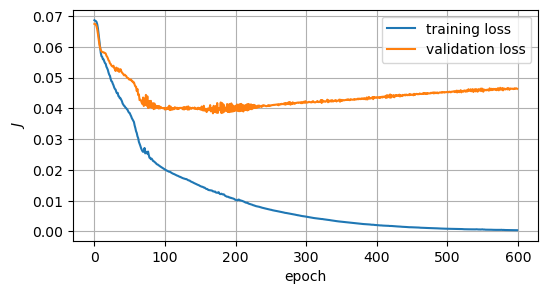

In [16]:
# intialise model, compile, train and plot loss

keras.utils.set_random_seed(4321)

# initialise model
autoencoder, encoder, decoder = ae_catdog()

# compile
learning_rate = 0.0005
autoencoder.compile(loss=keras.losses.MeanSquaredError(), 
                    # note the use of a different Adam
                    optimizer=keras.optimizers.AdamW(learning_rate=learning_rate,
                                                     weight_decay=0.001),
                    )

# train + validation (split out 20% of train data for validation)
train_log = autoencoder.fit(X_train, Y_train, 
                            epochs=600,
                            validation_split=0.2,  # get validation data from train set
                            verbose=0,
                            callbacks=[TqdmCallback(verbose=1)],
                           )

# plot the loss curves
fig = plt.figure(figsize=(6, 3))
ax = plt.axes()
ax.plot(train_log.epoch, train_log.history["loss"], label="training loss")
ax.plot(train_log.epoch, train_log.history["val_loss"], label="validation loss")
ax.set_xlabel("epoch")
ax.set_ylabel(r"$J$")
ax.grid()
ax.legend();

Below evaluates on both the train and test set.

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


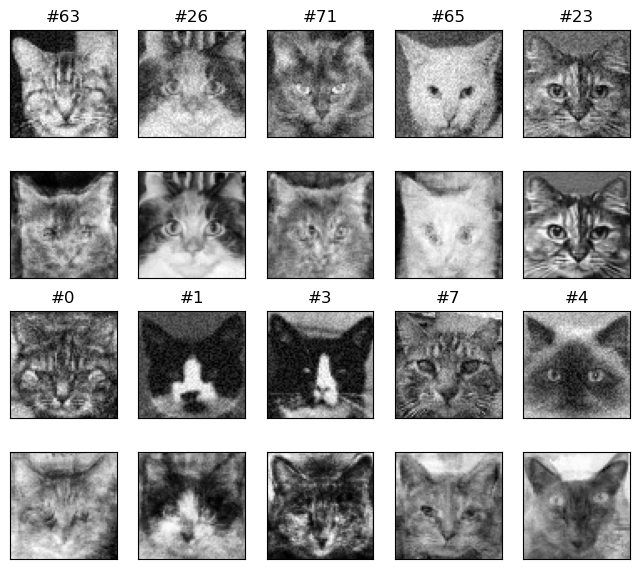

In [17]:
# sample show
predictions_train = autoencoder.predict(X_train)
predictions_test = autoencoder.predict(X_test)

# generate a list of indices (generate full list, shuffle, select first bit, so no repeats)
ind = np.arange(X_train.shape[0])
np.random.seed(123)
np.random.shuffle(ind)  # syntax for shuffle: not used like a function with input output...

fig = plt.figure(figsize=(8, 7))
for i in range(5):
    ax = plt.subplot(4, 5, i+1)
    ax.imshow(np.reshape(X_train[ind[i], :], (64, 64)).T, cmap="gray")
    ax.set_title(f"#{ind[i]}")
    ax.set_xticks([]); ax.set_yticks([]);
    ax = plt.subplot(4, 5, 5+i+1)
    ax.imshow(np.reshape(predictions_train[ind[i], :], (64, 64)).T, cmap="gray")
    ax.set_xticks([]); ax.set_yticks([]);

# same for test set
ind = np.arange(X_test.shape[0])
np.random.seed(123)
np.random.shuffle(ind)

for i in range(5):
    ax = plt.subplot(4, 5, 10+i+1)
    ax.imshow(np.reshape(X_test[ind[i], :], (64, 64)).T, cmap="gray")
    ax.set_title(f"#{ind[i]}")
    ax.set_xticks([]); ax.set_yticks([]);
    ax = plt.subplot(4, 5, 10+5+i+1)
    ax.imshow(np.reshape(predictions_test[ind[i], :], (64, 64)).T, cmap="gray")
    ax.set_xticks([]); ax.set_yticks([]);

It is at least believable for the train set, but it's not great on the test set in that it seems to be generating different cats! This is consistent with the loss curves above, and perhaps expected because the sample size is low so it doesn't know how to generalise.

As a just-for-fun test, I am going to hit the three ad-hoc TAs with the trained auto-encoder to see what cursedness results.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


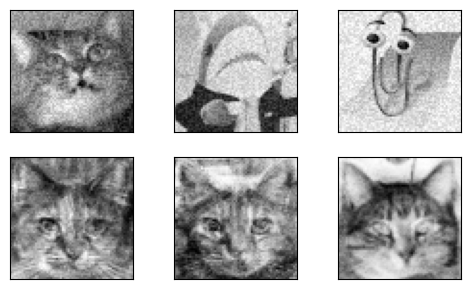

In [18]:
import requests
from PIL import Image
from io import BytesIO

# load data remotely
targets_path = {
    "miffy_gormless" : "https://raw.githubusercontent.com/julianmak/OCES5303_ML_ocean/refs/heads/main/miffy_gormless.jpg",
    "blauhaj" : "https://raw.githubusercontent.com/julianmak/OCES5303_ML_ocean/refs/heads/main/blauhaj.jpg",
    "clippy" : "https://raw.githubusercontent.com/julianmak/OCES5303_ML_ocean/refs/heads/main/clippy.jpg",
}

targets = {}

for file_name, file_url in targets_path.items():
    response = requests.get(file_url)
    targets[file_name] = Image.open(BytesIO(response.content))

# massage the data into the right shape, standardise it, and pass it to the model
data = np.concatenate( (np.array(targets["miffy_gormless"]).T.reshape(-1, 64**2),
                        np.array(targets["blauhaj"]).T.reshape(-1, 64**2),
                        np.array(targets["clippy"]).T.reshape(-1, 64**2),
                       ), dtype="float64"
                     )
data /= 255.0  # map it to [0, 1]
data += noise_level * np.random.rand(data.shape[0], 
                                     data.shape[1])
predictions_oos = autoencoder.predict(data)

# out-of-sample cursedness
fig = plt.figure(figsize=(6, 3.5))
for i in range(3):
    ax = plt.subplot(2, 3, i+1)
    ax.imshow(np.reshape(data[i, :], (64, 64)).T, cmap="gray")
    ax.set_xticks([]); ax.set_yticks([]);
    ax = plt.subplot(2, 3, 3+i+1)
    ax.imshow(np.reshape(predictions_oos[i, :], (64, 64)).T, cmap="gray")
    ax.set_xticks([]); ax.set_yticks([]);

> <span style="color:red">Q.</span> Experiment with changing the network architecture, train-test-validate ratios and the `noise_level` to see what impact this has on the model skill etc.

---
## b) Convolutional Autoencoders (CAEs)

The autoencoder above is just MLPs as encoder and decoders stuck together, and there is nothing stopping you doing the same thing using CNNs (or others, e.g. LSTM). That's basically what we are going to do here. Observe that going to lower dimensions is easy because a CNN does this anyway, so we don't have problems with defining the encoder. For the decoder we need the corresponding commands to "undo" those processes.

> NOTE: I use the word "undo" very loosely here, because you again you don't have to mirror the operations. I just mean that if we reduced dimension we need to increase dimension somehow for the input; see later on how you might do this.

Here we want to load data as images instead, and I am going to revisit the denoising problem. I am going to reload the data, split it, add noise, then reshape it into the image shape that `keras` is expecting (in the default form with "channel last" convention).


X_train shape : (72, 64, 64, 1); Y_train shape: (72, 64, 64, 1)
X_test shape: (8, 64, 64, 1); Y_test shape: (8, 64, 64, 1)

X_train : 0.0015307686209844462...1.197980186534433
X_test :  0.0026047363333552066...1.199740386569797


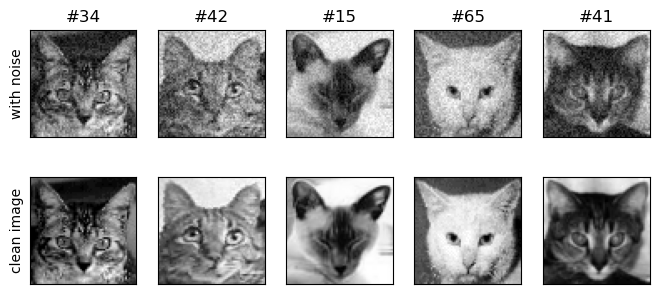

In [19]:
# load the data again for safety
seed = 42

# normalise to [0, 1]
X_total = X_cats / 255
Y_total = X_cats / 255

# only do train/test split; validation split later with keras
X_train, X_test, Y_train, Y_test = train_test_split(
    X_total, Y_total, train_size=0.90, random_state=seed,)

# add noise
noise_level = 0.2  # uniform noise with some magnitude (data here is NORMALISED to [0, 1])

X_train += noise_level * np.random.rand(X_train.shape[0], 
                                        X_train.shape[1])
X_test  += noise_level * np.random.rand(X_test.shape[0], 
                                        X_test.shape[1])

# reshape (channel last convention)
X_train, Y_train = X_train.reshape(-1, 64, 64, 1), Y_train.reshape(-1, 64, 64, 1)
X_test, Y_test = X_test.reshape(-1, 64, 64, 1), Y_test.reshape(-1, 64, 64, 1)

# check the shape
print()
print(f"X_train shape : {X_train.shape}; Y_train shape: {Y_train.shape}")
print(f"X_test shape: {X_test.shape}; Y_test shape: {Y_test.shape}")

# check the range of values
print()
print(f"X_train : {X_train.min()}...{X_train.max()}")
print(f"X_test :  {X_test.min()}...{X_test.max()}")

# generate a list of indices (generate full list, shuffle, select first whatever, so no repeats)
ind = np.arange(X_train.shape[0])
np.random.shuffle(ind)

fig = plt.figure(figsize=(8, 3.5))
for i in range(5):
    ax = plt.subplot(2, 5, i+1)
    ax.imshow(X_train[ind[i], :, :, 0].T, cmap="gray")
    ax.set_title(f"#{ind[i]}")
    if i == 0:
        ax.set_ylabel(r"with noise")
    ax.set_xticks([]); ax.set_yticks([]);
    ax = plt.subplot(2, 5, 5+i+1)
    ax.imshow(Y_train[ind[i], :, :, 0].T, cmap="gray")
    ax.set_xticks([]); ax.set_yticks([]);
    if i == 0:
        ax.set_ylabel(r"clean image")

Going to define the relevant convolution layers and architecture (I largely took it from [here](https://keras.io/examples/vision/autoencoder/)). The things we are doing are that:

* Encoder is the usual, but we "pad" it out accordingly when doing the `Conv2D`, so that only the `MaxPooling` is reducing the dimensions (by a factor of 2).
* The `Conv2DTranspose` "undo"s the `Conv2D` operations.
* The `strides=2` are there to "undo" the convolution every two steps and blow the data back up to the original dimension (to mirror the `MaxPooling` in terms of what it is doing to the data dimensions).

Note that this autoencoder is not symmetric, in the sense that the decoder is not exactly "undo"ing the operations of the encoder. That is allowed, as you can do whatever you want in some sense. There are other ways to define the decoder to get the dimensions you want for defining the autoencoder.

Thing you probably want to do is to convince yourself the specified dimensions here make sense.

> NOTE: You could "cheat" a bit here with the dimension checking (like I realised later). You can define every operation explicitly, e.g.
```Python
x = layers.Conv2D(32, (3, 3), activation="relu", padding="same")(inputs)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
...
x = layers.Conv2DTranspose(32, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)
```
> form the model and then call `.summary()`, which will then tell you what the dimensions are at each step, then you write these back into the subroutine properly.
>
> In that sense `keras` is quite nice in that it will try make things work, and you can also query what it did try and do for fixing other things. In `PyTorch` you would need to be very specific with the inputs and outputs (like I did the first time round...)

In [20]:
# define really simple auto-encoder (two parts jammed together: encoder and decoder)

def convae_catdog():

    # 1) define the autoencoder and the layers
    inputs = keras.Input(shape=(64, 64, 1))
    encoded = keras.Sequential(
        [
            layers.Conv2D(32, (3, 3), activation="relu", padding="same"),
            layers.MaxPooling2D((2, 2), padding="same"),
            layers.Conv2D(32, (3, 3), activation="relu", padding="same"),
            layers.MaxPooling2D((2, 2), padding="same"),
        ]
    )(inputs)  # input to be passed here
    decoded = keras.Sequential(
        [
            layers.Conv2DTranspose(32, (3, 3), strides=2, 
                                   activation="relu", padding="same"),
            layers.Conv2DTranspose(32, (3, 3), strides=2, 
                                   activation="relu", padding="same"),
            layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same"),
        ]
    )(encoded)
    autoencoder = keras.Model(inputs, decoded, name="autoencoder")

    # 2) pull out the encoder
    encoder = keras.Model(inputs, encoded, name="encoder")

    # 3) pull out the decoder (this one needs a bit more syntax)
    encoded_input = keras.Input(shape=(16, 16, 32,)) # <--- CAREFUL HERE
    decoder_layer = autoencoder.layers[-1]
    decoder = keras.Model(encoded_input, decoder_layer(encoded_input), name="decoder")

    return autoencoder, encoder, decoder

# initialise the model and see what it has
dummy, _, _ = convae_catdog()
dummy.summary()

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_16 (InputLayer)     │ (None, 64, 64, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_6 (Sequential)       │ (None, 16, 16, 32)     │         9,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_7 (Sequential)       │ (None, 64, 64, 1)      │        18,785 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 28,353 (110.75 KB)

 Trainable params: 28,353 (110.75 KB)

 Non-trainable params: 0 (0.00 B)

I am going to train for substantially fewer epochs compared to the MLP based autoencoder above (300 vs. 600).

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

/home/jclmak/miniconda3/envs/py311/lib/python3.11/site-packages/keras/src/backend/common/backend_utils.py:91: UserWarning: You might experience inconsistencies across backends when calling conv transpose with kernel_size=3, stride=2, dilation_rate=1, padding=same, output_padding=1.
  warnings.warn(


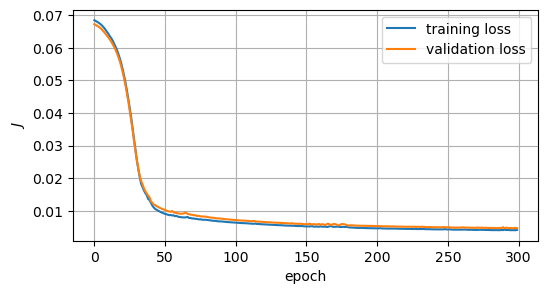

In [21]:
# intialise model, compile, train and plot loss

keras.utils.set_random_seed(4321)

# initialise model
autoencoder, encoder, decoder = convae_catdog()

# compile
learning_rate = 0.0005
autoencoder.compile(loss=keras.losses.MeanSquaredError(), 
                    # note the use of a different Adam
                    optimizer=keras.optimizers.AdamW(learning_rate=learning_rate,
                                                     weight_decay=0.001),
                    )

# train + validation (split out 20% of train data for validation)
train_log = autoencoder.fit(X_train, Y_train, 
                            epochs=300,
                            validation_split=0.2,  # get validation data from train set
                            verbose=0,
                            callbacks=[TqdmCallback(verbose=1)],
                           )

# plot the loss curves
fig = plt.figure(figsize=(6, 3))
ax = plt.axes()
ax.plot(train_log.epoch, train_log.history["loss"], label="training loss")
ax.plot(train_log.epoch, train_log.history["val_loss"], label="validation loss")
ax.set_xlabel("epoch")
ax.set_ylabel(r"$J$")
ax.grid()
ax.legend();

The losses look good in this case. Lets see what the images actually look like.

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


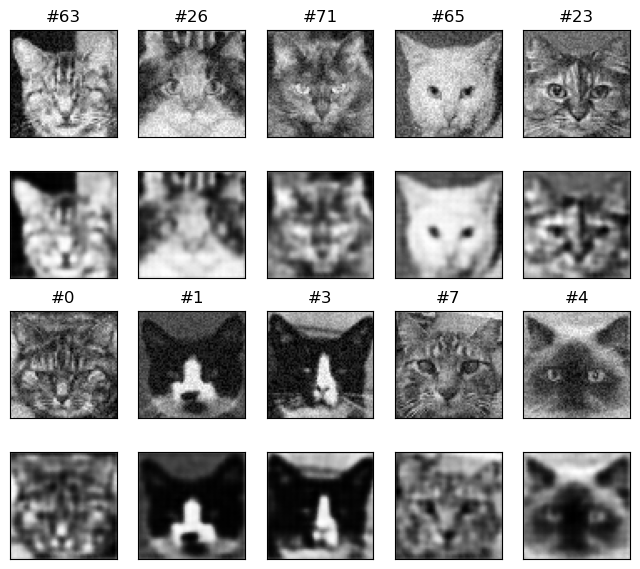

In [22]:
# sample show
predictions_train = autoencoder.predict(X_train)
predictions_test = autoencoder.predict(X_test)

# generate a list of indices (generate full list, shuffle, select first bit, so no repeats)
ind = np.arange(X_train.shape[0])
np.random.seed(123)
np.random.shuffle(ind)  # syntax for shuffle: not used like a function with input output...

fig = plt.figure(figsize=(8, 7))
for i in range(5):
    ax = plt.subplot(4, 5, i+1)
    ax.imshow(np.reshape(X_train[ind[i], :], (64, 64)).T, cmap="gray")
    ax.set_title(f"#{ind[i]}")
    ax.set_xticks([]); ax.set_yticks([]);
    ax = plt.subplot(4, 5, 5+i+1)
    ax.imshow(np.reshape(predictions_train[ind[i], :], (64, 64)).T, cmap="gray")
    ax.set_xticks([]); ax.set_yticks([]);

# same for test set
ind = np.arange(X_test.shape[0])
np.random.seed(123)
np.random.shuffle(ind)

for i in range(5):
    ax = plt.subplot(4, 5, 10+i+1)
    ax.imshow(np.reshape(X_test[ind[i], :], (64, 64)).T, cmap="gray")
    ax.set_title(f"#{ind[i]}")
    ax.set_xticks([]); ax.set_yticks([]);
    ax = plt.subplot(4, 5, 10+5+i+1)
    ax.imshow(np.reshape(predictions_test[ind[i], :], (64, 64)).T, cmap="gray")
    ax.set_xticks([]); ax.set_yticks([]);

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


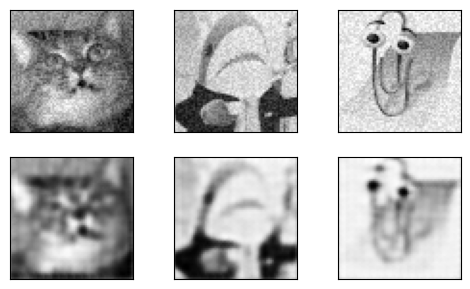

In [23]:
import requests
from PIL import Image
from io import BytesIO

# load data remotely
targets_path = {
    "miffy_gormless" : "https://raw.githubusercontent.com/julianmak/OCES5303_ML_ocean/refs/heads/main/miffy_gormless.jpg",
    "blauhaj" : "https://raw.githubusercontent.com/julianmak/OCES5303_ML_ocean/refs/heads/main/blauhaj.jpg",
    "clippy" : "https://raw.githubusercontent.com/julianmak/OCES5303_ML_ocean/refs/heads/main/clippy.jpg",
}

targets = {}

for file_name, file_url in targets_path.items():
    response = requests.get(file_url)
    targets[file_name] = Image.open(BytesIO(response.content))

# massage the data into the right shape, standardise it, and pass it to the model
data = np.concatenate( (np.array(targets["miffy_gormless"]).T.reshape(-1, 64**2),
                        np.array(targets["blauhaj"]).T.reshape(-1, 64**2),
                        np.array(targets["clippy"]).T.reshape(-1, 64**2),
                       ), dtype="float64"
                     )
data /= 255.0  # map it to [0, 1]
data += noise_level * np.random.rand(data.shape[0], 
                                     data.shape[1])
data = data.reshape(-1, 64, 64, 1)
predictions_oos = autoencoder.predict(data)

# out-of-sample cursedness
fig = plt.figure(figsize=(6, 3.5))
for i in range(3):
    ax = plt.subplot(2, 3, i+1)
    ax.imshow(np.reshape(data[i, :], (64, 64)).T, cmap="gray")
    ax.set_xticks([]); ax.set_yticks([]);
    ax = plt.subplot(2, 3, 3+i+1)
    ax.imshow(np.reshape(predictions_oos[i, :], (64, 64)).T, cmap="gray")
    ax.set_xticks([]); ax.set_yticks([]);

So it's doing better in that it is at least preserving the images so that the output is at least the same cat/ad-hoc TA, but it is pretty blurred.

> <span style="color:red">Q.</span> You could have used `layers.UpSampling2D((2, 2))` to "undo" the `layers.MaxPooling2D((2, 2))` instead, and not use `layers.Conv2dTranspose(...,stride=2, ...)`. See if that makes any difference (notably if it will make the output images sharper).
> 
> <span style="color:red">Q.</span> You don't strictly need to use `layers.Conv2dTranspose` I suppose for square images, because `layers.Conv2d` would be fine also (why?). Try swapping it out and convincing yourself it doesn't matter (then you can suppress a warning about `Conv2dTranspose` may not be consistent depending on backend).

### Choice of loss function?

So when I was reading [this example](https://keras.io/examples/vision/autoencoder/) I noticed they use `BinaryCrossentropy()` as the loss function, which puzzled me because that didn't seem to make theoretical sense to me. Upon reading a bit more, the conclusions largely seems to be that "it is machine learning so you can do whatever you want as long as it works" (well within reason, e.g. you can't really use MSE for classification problems)...

A more nuanced rationale is that when you are optimising you want to find the optimum, but the optimum doesn't have to be zero necessarily. Sure your MSE would be zero if the images match completely, but it doesn't mean the images are not "good" if you choose another loss function that is not zero at the optimum. Main point is that it isn't **not** invalid (double negative here), although in that sense introduces an extra dimension for hyper-parameter selection.

Below swaps out the loss function as well changing the solver and adding batching in. The results are largely similar to above though, but then again the images used here are more complex and much smaller in sample size than the MNIST dataset in the example on the `keras` webpage.

0epoch [00:00, ?epoch/s]

0batch [00:00, ?batch/s]

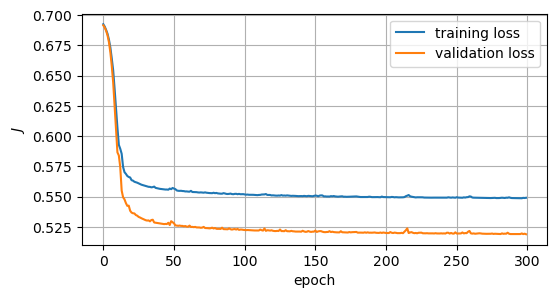

In [24]:
# intialise model, compile, train and plot loss

keras.utils.set_random_seed(4321)

# initialise model
autoencoder, encoder, decoder = convae_catdog()

# compile
learning_rate = 0.001
autoencoder.compile(loss=keras.losses.BinaryCrossentropy(), 
                    # note the use of a different Adam
                    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                    )

# train + validation (split out 20% of train data for validation)
train_log = autoencoder.fit(X_train, Y_train, 
                            epochs=300,
                            validation_split=0.1,  # get validation data from train set
                            batch_size=20,
                            verbose=0,
                            callbacks=[TqdmCallback(verbose=1)],
                           )

# plot the loss curves
fig = plt.figure(figsize=(6, 3))
ax = plt.axes()
ax.plot(train_log.epoch, train_log.history["loss"], label="training loss")
ax.plot(train_log.epoch, train_log.history["val_loss"], label="validation loss")
ax.set_xlabel("epoch")
ax.set_ylabel(r"$J$")
ax.grid()
ax.legend();

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


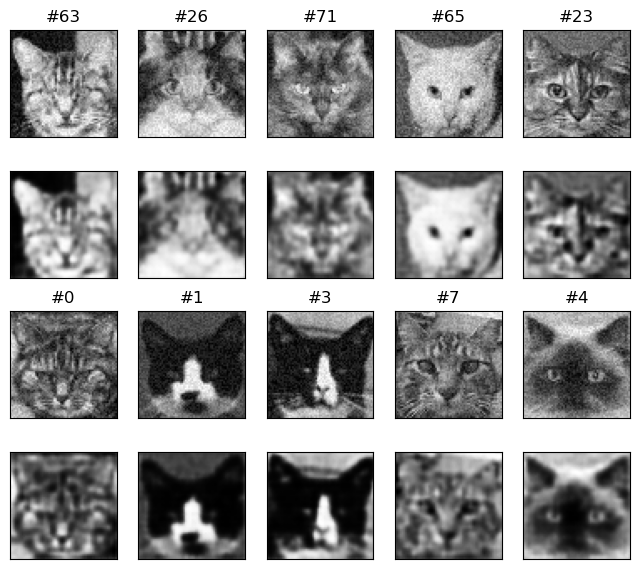

In [25]:
# sample show
predictions_train = autoencoder.predict(X_train)
predictions_test = autoencoder.predict(X_test)

# generate a list of indices (generate full list, shuffle, select first bit, so no repeats)
ind = np.arange(X_train.shape[0])
np.random.seed(123)
np.random.shuffle(ind)  # syntax for shuffle: not used like a function with input output...

fig = plt.figure(figsize=(8, 7))
for i in range(5):
    ax = plt.subplot(4, 5, i+1)
    ax.imshow(np.reshape(X_train[ind[i], :], (64, 64)).T, cmap="gray")
    ax.set_title(f"#{ind[i]}")
    ax.set_xticks([]); ax.set_yticks([]);
    ax = plt.subplot(4, 5, 5+i+1)
    ax.imshow(np.reshape(predictions_train[ind[i], :], (64, 64)).T, cmap="gray")
    ax.set_xticks([]); ax.set_yticks([]);

# same for test set
ind = np.arange(X_test.shape[0])
np.random.seed(123)
np.random.shuffle(ind)

for i in range(5):
    ax = plt.subplot(4, 5, 10+i+1)
    ax.imshow(np.reshape(X_test[ind[i], :], (64, 64)).T, cmap="gray")
    ax.set_title(f"#{ind[i]}")
    ax.set_xticks([]); ax.set_yticks([]);
    ax = plt.subplot(4, 5, 10+5+i+1)
    ax.imshow(np.reshape(predictions_test[ind[i], :], (64, 64)).T, cmap="gray")
    ax.set_xticks([]); ax.set_yticks([]);

> <span style="color:red">Q.</span> Experiment with changing the network architecture, dataset ratios, the `noise_level` and other hyper-parameters to see what impact this has on the model skill etc.
>
> You could also do this on the MNIST dataset, which is smaller in image size but has a much larger sample size that will presumably help with the training.

----------------
# More involved exercises with this notebook

## 1) Using the larger cats image dataset

The above codes demonstrate how an autoencoder works but the performance is not great, largely attributed to the sample size being rather low. Have a look at using the larger set of cats images that I used for eigencat in a previous session instead.

## 2) Implementation in `PyTorch`

Good exercise to try and see how you would do the same thing in `PyTorch` (to appreciate how `keras` makes things that much easier).

## 3) Variational Autoencoders

Have a look towards the bottom of [this page](https://blog.keras.io/building-autoencoders-in-keras.html) for a demonstration of what a ***Variational Autoencoder*** is, and try and implement this for yourself. Note that the code set is out of date in that entry; this [more updated one](https://github.com/keras-team/keras-io/blob/master/examples/generative/vae.py) may help, but you still need to modify it assuming you don't use an unholy mix of `TensorFlow` together with `PyTorch`.

You will probably also need to read up on what the ***KL divergence*** is, in relation to how the loss function is defined.

## 4) Map data of some sort

Below may be ideas for the extended project.

Try and find some spatio-temporal data on a regular grid (e.g. satellite products, numerical simulation data), and train an autoencoder to reconstruct missing grid cells (that you artificially remove for example) or similar reconstruction tasks.

One thing we know is that autoencoders in the latent space representation is a bit like a PCA, which is related to finding EOFs (Empirical Orthogonal Functions). Climate variability such as El-Nino (ENSO) is usually picked out by EOFs, so see if what you actually get if you apply autoencoders to the associated data instead. There is some reconstructed SST data [here](https://github.com/julianmak/OCES3301_data_analysis/raw/refs/heads/main/ersstv5_ssta.nc); you can look into my OCES 3301 lecture 9/10 and assignment 3 to see what kind of manipulations you would need to do in the "tradional" sense if you haven't done it before.

## 5) Using MNIST data

Try doing standard/convolution/variational autoencoders for the MNIST data or similar; see previous extended exercises for where to get those etc.